In [1]:
import numpy as np
from glob import glob
import os

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.style.use('thesis')

from scipy.optimize import curve_fit

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Build a dictionary of the data

In [2]:
data_path = '/Users/clarke/Documents/Research/Nanospheres/Data/'
base_path = '/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/'
drive_path = '/Volumes/LaCie/'
# base_path = '/Volumes/LaCie/pulse_calibration/sphere_20250406/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    datasets[folder.split(base_path)[-1]] = sub_datasets

20250910_electric_calibration_5e-8mbar_0
	20250910_d_p10e_73khz_10vpp
	20250910_d_p10e_nodrive
20250910_p10e_5e-8mbar_30khz_d93khz_0
	20250910_dfg_p10e_200ns_10v
	20250910_dfg_p10e_200ns_15v
	20250910_dfg_p10e_200ns_20v
	20250910_dfg_p10e_200ns_5v
20250910_electric_calibration_5e-8mbar_1
	20250910_d_p10e_93khz_10vpp
	20250910_d_p10e_nodrive
20250911_electric_calibration_4e-8mbar_0
	20250911_d_p10e_93khz_10vpp
	20250911_d_p10e_nodrive
20250911_p10e_4e-8mbar_30khz_d93khz_0
	20250911_dfg_p10e_200ns_10v
	20250911_dfg_p10e_200ns_15v
	20250911_dfg_p10e_200ns_20v
	20250911_dfg_p10e_200ns_5v


In [3]:
channel_map = {'d': 'backscattered', \
               'g': 'impulse', \
               'f': 'monitoring'}

pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174])
pulse_amps_V = np.arange(2.5, 21, 2.5)

t_window = 1e-3 # half the window length in ms
f_cutoff_high = 3.5e4 # upper cutoff frequency for the bandpass filter
f_cutoff_low = 2.5e4 # lower cutoff frequency for the bandpass filter
f_cutoff = [f_cutoff_low, f_cutoff_high]

In [38]:
reload(dp)

# choose which dataset to look at
dataset_ind = 4
dataset = list(datasets.keys())[dataset_ind]

pulse_amps_keV = []
impulses = []
resonance_params = []

plot = True
max_files = 1

# loop through all four files in that dataset in the correct order
for i, file_ind in enumerate([3]):#, 0, 1, 2]): # [3, 0, 1, 2]
    filename = datasets[list(datasets.keys())[dataset_ind]][file_ind]
    plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + filename \
                if plot else None
    nd = dp.NanoDataset(base_path + dataset + '/' + filename, plot_path, \
                        t_window=t_window, f_cutoff=f_cutoff, verbose=True, max_files=max_files)
    nd.load_files(pulse_amps_1e=pulse_amps_1e, pulse_amps_V=pulse_amps_V)
    impulses.append(nd.forces.copy())
    pulse_amps_keV.append(nd.pulse_amp_keV.copy())
    resonance_params.append(nd.resonance_params.copy())

    del nd

Loading file 1...
Fit succeeded
[2.91525400e-06 1.72838897e+05 2.28528639e+04 5.49514732e-03
 2.90957089e-13]
-> Computing force for impulse at t=0.05791 seconds...
-> Computing force for impulse at t=0.35790 seconds...
-> Computing force for impulse at t=0.65790 seconds...
-> Computing force for impulse at t=0.95790 seconds...
-> Computing force for impulse at t=1.25789 seconds...
-> Computing force for impulse at t=1.55789 seconds...
-> Computing force for impulse at t=1.85788 seconds...


/Users/clarke/Documents/Research/Nanospheres/Analysis/data_processing.py:303: OptimizeWarning: Covariance of the parameters could not be estimated
  p, _ = curve_fit(abs_susc2, omega, Pxx_fit, p0=p0)#, sigma=Pxx_fit, absolute_sigma=True)


-> Computing force for impulse at t=2.15788 seconds...
-> Computing force for impulse at t=2.45788 seconds...
-> Computing force for impulse at t=2.75787 seconds...
-> Computing force for impulse at t=3.05787 seconds...
-> Computing force for impulse at t=3.35786 seconds...
-> Computing force for impulse at t=3.65786 seconds...
-> Computing force for impulse at t=3.95785 seconds...
-> Computing force for impulse at t=4.25785 seconds...
-> Computing force for impulse at t=4.55785 seconds...
-> Computing force for impulse at t=4.85784 seconds...
-> Computing force for impulse at t=5.15784 seconds...
-> Computing force for impulse at t=5.45783 seconds...
-> Computing force for impulse at t=5.75783 seconds...


Text(0.5, 0, 'Dataset')

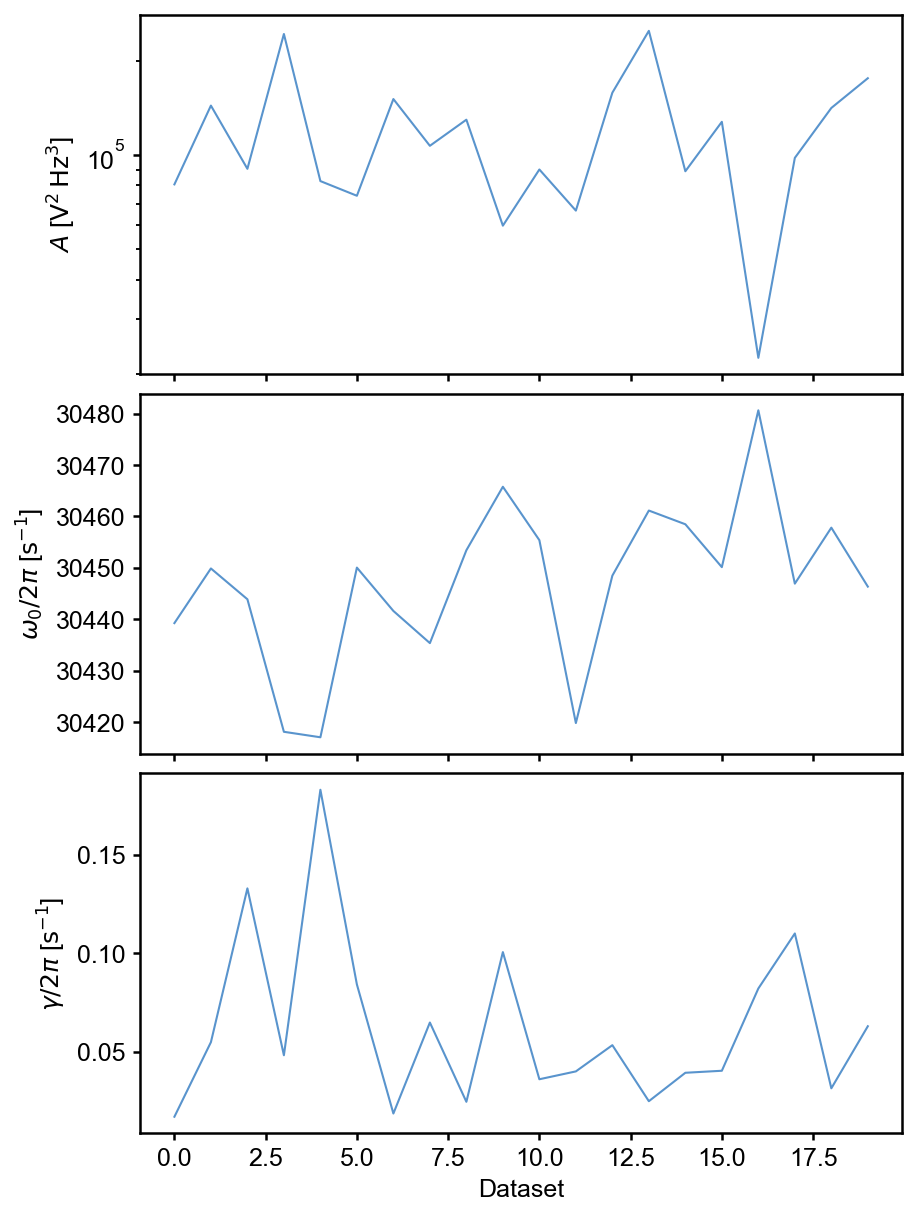

In [110]:
resonance_params = np.array(resonance_params)
resonance_params.shape

fig, ax = plt.subplots(3, figsize=(6, 8), sharex=True, layout='constrained')
ax[0].semilogy(resonance_params[0, :, 0], label='$A$')
ax[1].plot(resonance_params[0, :, 1]/2/np.pi)
ax[2].plot(resonance_params[0, :, 2]/2/np.pi)
ax[0].set_ylabel(r'$A$ [$\mathrm{V^2\,Hz^3}$]')
ax[1].set_ylabel(r'$\omega_0/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2].set_ylabel(r'$\gamma/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2].set_xlabel('Dataset')

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_35833/1741154772.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('$|\chi(\omega)|^2$')
/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_35833/1741154772.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('$|\chi(\omega)|^2$')


AttributeError: 'list' object has no attribute 'shape'

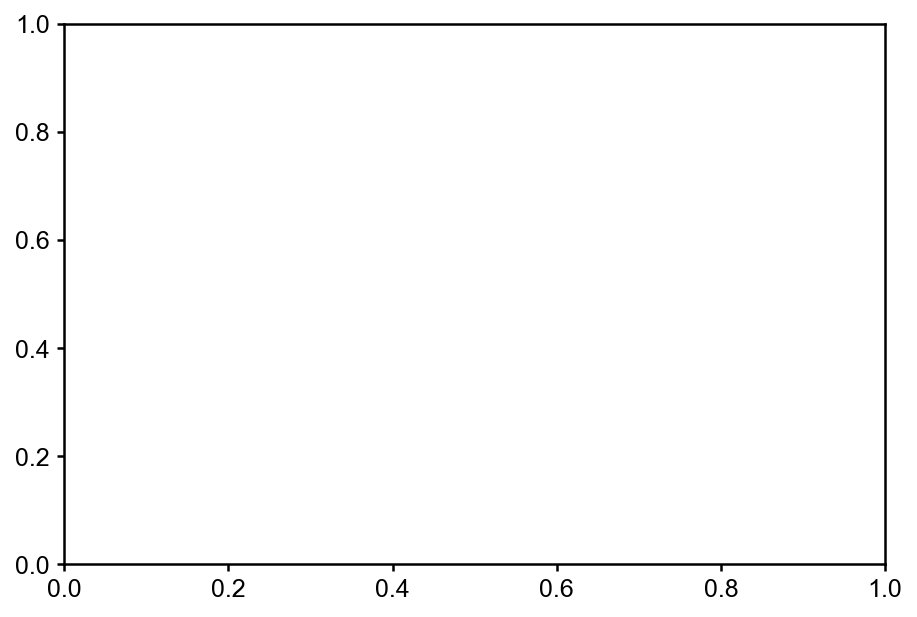

In [27]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

omegas = np.linspace(1.5e5, 2.5e5, 200)
colors = [plt.get_cmap('plasma', resonance_params.shape[1])(i) for i in range(resonance_params.shape[1])]

for i, params in enumerate(resonance_params[0, :]):
    ax.plot(omegas/2/np.pi, dp.abs_susc2(omegas, *params), alpha=0.3, color=colors[i])

ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('$|\chi(\omega)|^2$')
ax.set_title('Resonance drift')
ax.grid()
fig.colorbar(ScalarMappable(norm=Normalize(0, resonance_params.shape[1]), cmap='plasma'), ax=ax, label='Pulse number', pad=0.01)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_3800/2742089581.py:3: SyntaxWarning: invalid escape sequence '\m'
  fig = corner.corner(resonance_params[0], labels=['$A$ [$\mathrm{V^2\,Hz^3}$]', \
/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_3800/2742089581.py:4: SyntaxWarning: invalid escape sequence '\o'
  '$\omega_0$ [$\mathrm{s}^{-1}$]', \
/var/folders/7j/dr4jyt_56g3ccfjw_z3l9n640000gn/T/ipykernel_3800/2742089581.py:5: SyntaxWarning: invalid escape sequence '\g'
  '$\gamma$ [$\mathrm{s}^{-1}$]'])


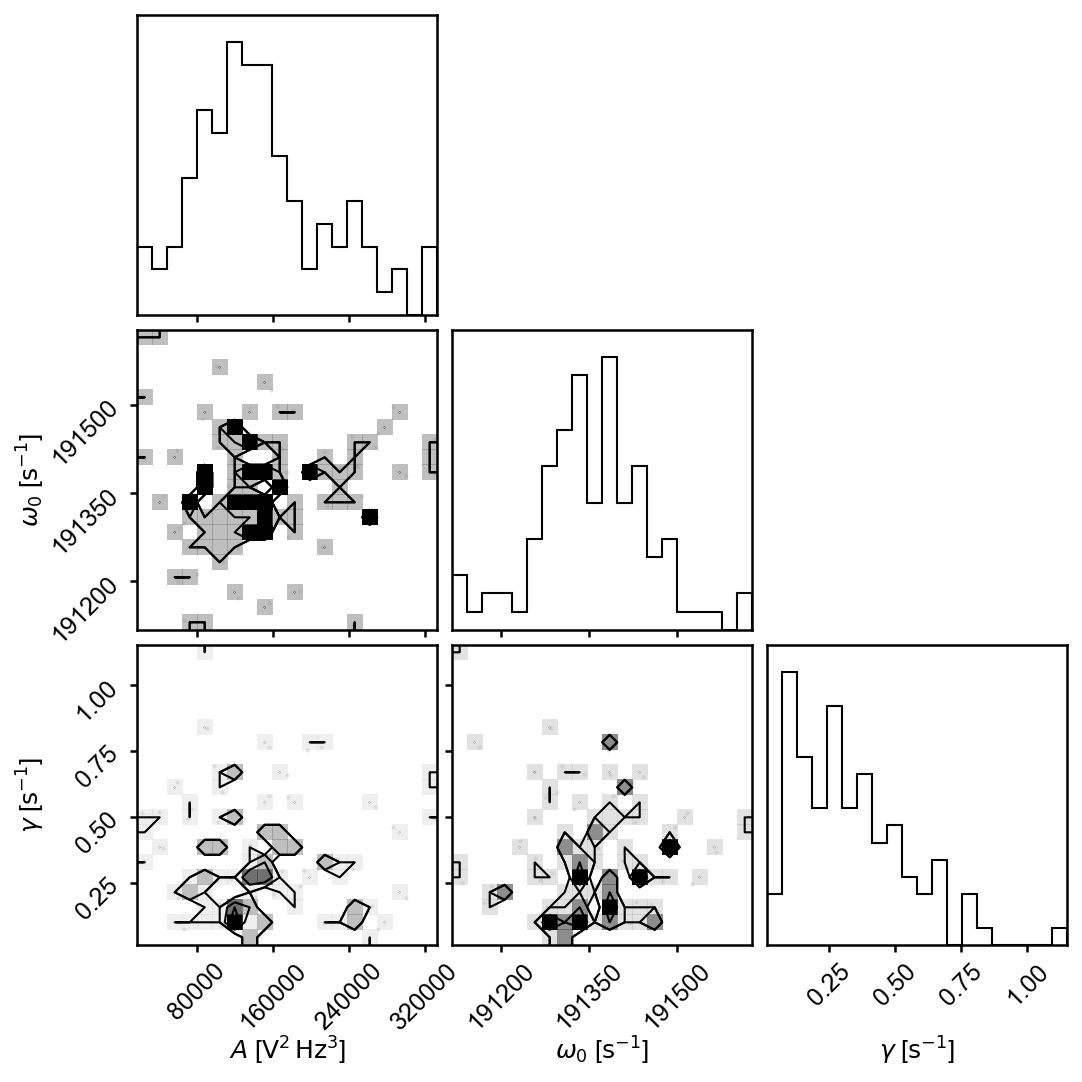

In [62]:
import corner

fig = corner.corner(resonance_params[0], labels=['$A$ [$\mathrm{V^2\,Hz^3}$]', \
                                                 '$\omega_0$ [$\mathrm{s}^{-1}$]', \
                                                 '$\gamma$ [$\mathrm{s}^{-1}$]'])

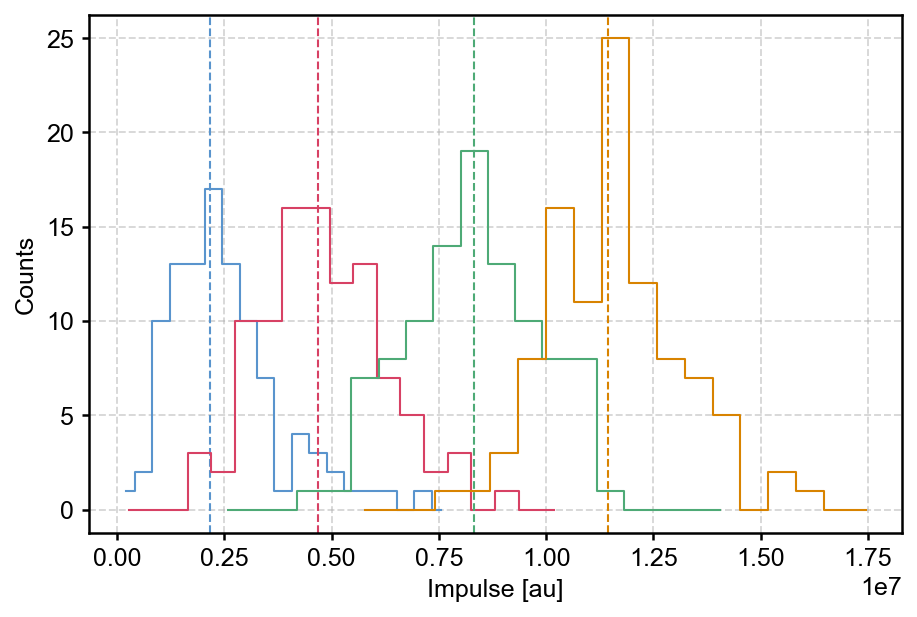

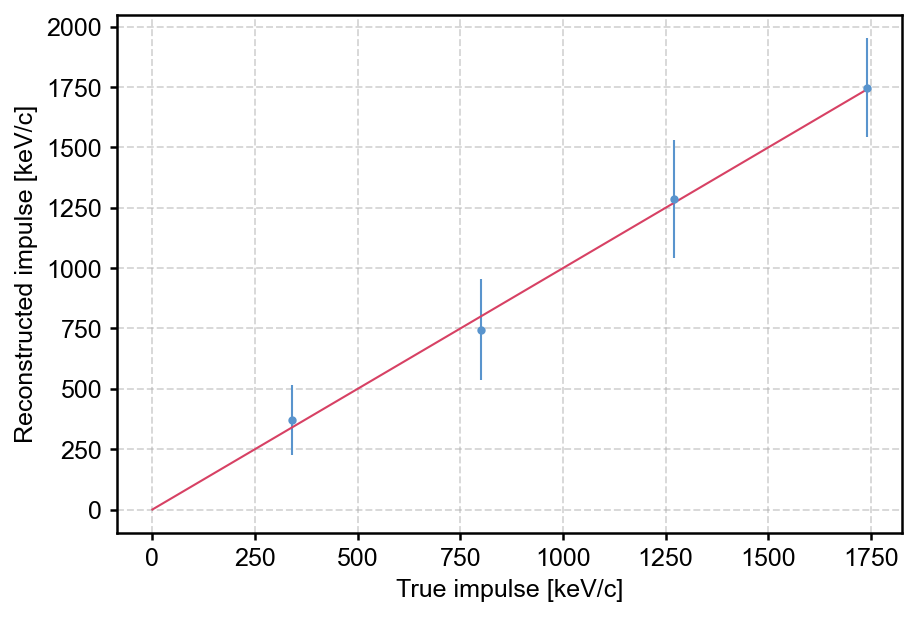

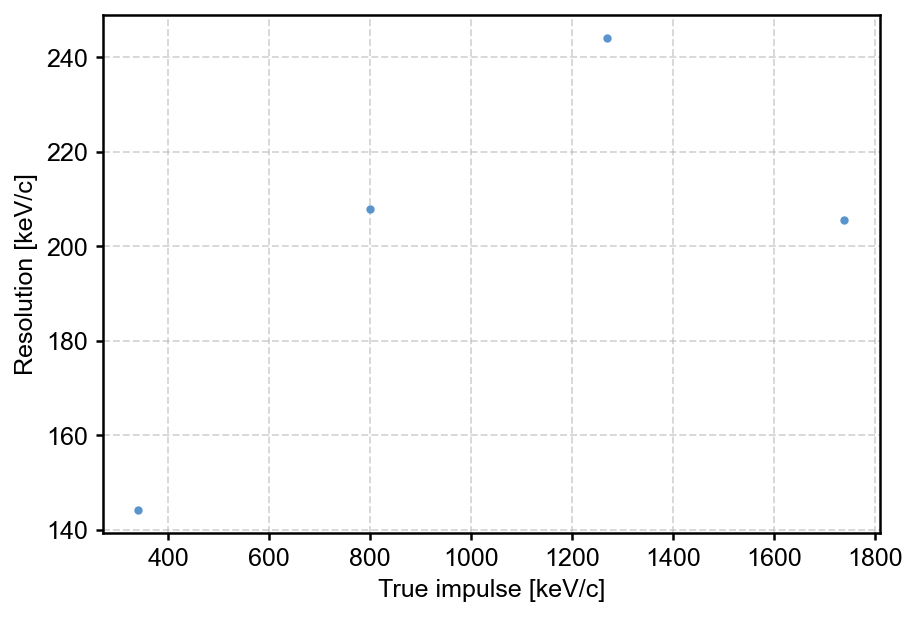

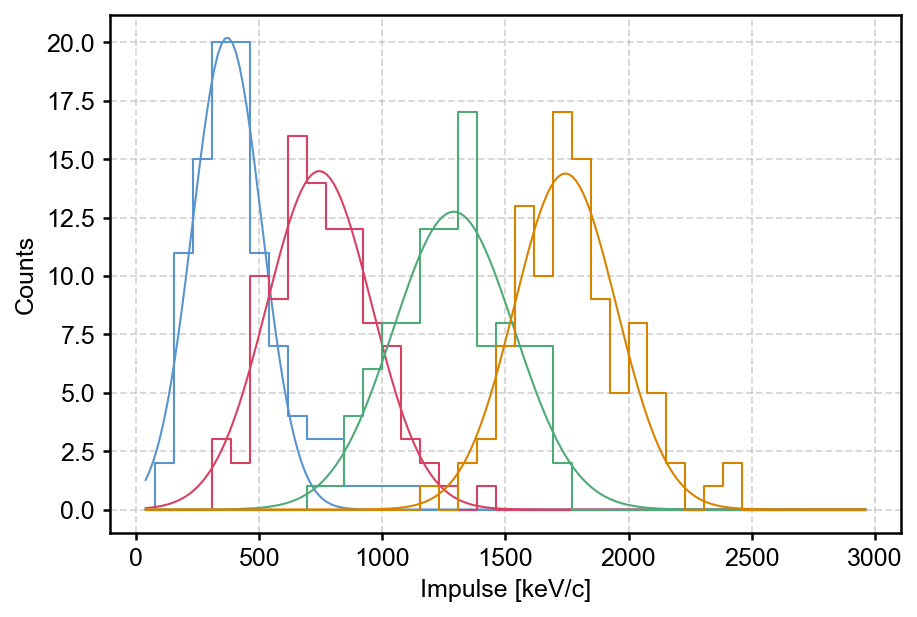

In [28]:
def gaus(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/2/sigma**2)

def linear(x, m, b):
    return m*x + b

means = []
errs = []

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    mean = np.mean(np.abs(imp))
    std = np.std(np.abs(imp))
    counts, bins = np.histogram(np.abs(imp), bins=np.linspace(np.amax((0, mean - 4*std)), mean + 4*std, 20))
    bins = (bins[:-1] + bins[1:])/2.
    p, _ = curve_fit(gaus, bins, counts, p0=(10, np.mean(np.abs(imp)), np.std(np.abs(imp))))
    plot_bins = np.linspace(bins[0], bins[-1], 200)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    # ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i))
    means.append(p[1])
    errs.append(p[2])
    ax.axvline(p[1], ls='--', color='C' + str(i))
ax.set_xlabel('Impulse [au]')
ax.set_ylabel('Counts')
# ax.set_xlim([0, 250])
ax.grid()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plot_amps = np.linspace(0, pulse_amps_keV[-1], 200)
cal_params, _ = curve_fit(linear, pulse_amps_keV, means)
ax.errorbar(pulse_amps_keV, means/cal_params[0] - cal_params[1]/cal_params[0], errs/cal_params[0], marker='.', ls='none')
ax.plot(plot_amps, linear(plot_amps, *cal_params)/cal_params[0] - cal_params[1]/cal_params[0])
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Reconstructed impulse [keV/c]')
ax.grid()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plot_amps = np.linspace(0, pulse_amps_keV[-1], 200)
cal_params, _ = curve_fit(linear, pulse_amps_keV, means)
ax.plot(pulse_amps_keV, errs/cal_params[0], marker='.', ls='none')
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Resolution [keV/c]')
ax.grid()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    imp_cal = np.abs(imp)/cal_params[0] - cal_params[1]/cal_params[0]
    counts, bins = np.histogram(imp_cal, bins=np.linspace(0, 3000, 40))
    bins = (bins[:-1] + bins[1:])/2.
    p, _ = curve_fit(gaus, bins, counts, p0=(10, np.mean(imp_cal), np.std(imp_cal)))
    plot_bins = np.linspace(bins[0], bins[-1], 200)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i))
    means.append(p[1])
    # ax.hist(np.abs(imp), histtype='step', bins=np.linspace(0, 5e-3, 20))
    # ax.axvline(np.mean(np.abs(imp)), ls='--', color='C' + str(i))
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Counts')
ax.grid()

In [ ]:
errs/cal_params[0]

### Look at some pulses

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('figures/output.pdf')

for i in range(5):
    fig, ax = plt.subplots()
    ax.plot(range(10), [j * (i+1) for j in range(10)])
    ax.set_title(f'Figure {i+1}')
    pdf.savefig(fig)   # save to PDF
    plt.close(fig)

# # optional metadata
# info = pdf.infodict()
# info['Title'] = 'My Results'
# info['Author'] = 'Clarke Hardy'
# info['Subject'] = 'Simulation plots'

pdf.close()  # you must close it manually